# Generative model of Labels, Abilities, and Difficulties (GLAD)


Consider the following probabilistic model:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

where $l_{ij} -$ $j$ expert response to the task $i$, $z_j -$  true markup, $\alpha_i, \beta_j-$ level of expertise and complexity of the task respectively. For more detailed description of the model, you can read the seminar materials as well as [original article](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [375]:
import numpy as np
from scipy.special import expit, softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
seed = 0xDEADF00D
np.random.seed(seed)

In [7]:
L = np.load('L.npy')
n, m = L.shape

**Task 1.** Implement the EM algorithm for the above model. You can use the suggested templates or write your own. 

Note that plausibility models not the probability of the label $l_{ij}$ to take a value of 1 or 0, but the probability that it is equal to the hidden variable $z_i$, i.e. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. It is not known beforehand which of the hidden variables corresponds to label 1. Do not forget that the parameters $\beta_i$ must be non-negative, to do this optimize $\log \beta$. 

Also don't forget about accuracy when working with probabilities:
1. use logarithms of probabilities.
2. $\log \sigma(a)$ should be converted to $\log \sigma(a) = -\log(1 + \exp(-a)). = -\mathrm{softplus}(-a) $
3. Other useful features. `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

For debugging it may be useful to check the gradient with `scipy.optimize.check_grad'.

In [27]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [331]:
#beta = np.loadtxt('beta.txt')
#alpha = np.loadtxt('alpha.txt')

In [332]:
def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    
    sigmoid = np.dot(beta[:, None], alpha[:, None].T)
    
    one_class_prob_model = np.multiply(L, softplus(sigmoid)) + np.multiply((1 - L), softplus(-sigmoid))
    zero_class_prob_model = np.multiply((1- L), softplus(sigmoid)) + np.multiply(L, softplus(-sigmoid))
    
    
    #one_class_prob = one_class.sum(axis=1) / (one_class.sum(axis=1) + zero_class.sum(axis=1))
    #zero_class_prob = zero_class.sum(axis=1) / (one_class.sum(axis=1) + zero_class.sum(axis=1))
    
    sum_matrix = np.vstack((one_class_prob_model.sum(axis=1), zero_class_prob_model.sum(axis=1)))
    
    return softmax(sum_matrix, axis=0)

def log_likelihood(alpha, beta, L, z):
    """ p(l=z|z, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        z: ndarray of shape (n_problems).
    """
    
    identity = np.equal(L, z[:, None])
    sigmoid = expit(np.dot(np.matrix(beta).T, np.matrix(alpha)))
    p = sigmoid * equal + (1 - sigmoid) * (1 - equal)
    log_p = np.log(p).sum()
    
    return log_p


def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    
    sigmoid = expit(np.dot(beta[:, None], alpha[:, None].T))
    diff_q = np.multiply((np.multiply(q[0][:, None], L==1) + np.multiply(q[1][:, None], L==0) - sigmoid), beta[:, None])
    
    return np.sum(diff_q, axis=0)


def logbeta_grad_lb(alpha, beta, L, q):
    
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    
    sigmoid = expit(np.dot(beta[:, None], alpha[:, None].T))
    #q = posterior(alpha, beta, L)
    diff_q = np.multiply((np.multiply(q[0][:, None], L==1) + np.multiply(q[1][:, None], L==0) - sigmoid), alpha)
    
    logbeta_diff_q = np.multiply(np.sum(diff_q, axis=1), beta[:, None][:, 0]) 
                                 
    return logbeta_diff_q

def lower_bound(alpha, beta, L, q):
    """ Lower bound
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    
    
    pass

In [336]:
def em(L, n_steps=1000, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(logbeta))) * 0.5
    
    
    for step in range(n_steps):
        beta = np.exp(logbeta)
        # E-step
        q = posterior(alpha, beta, L)
        # M-step
        alpha += alpha_grad_lb(alpha, beta, L, q) * lr
        logbeta += logbeta_grad_lb(alpha, beta, L, q) * lr
        
    return alpha, logbeta, q

In [337]:
alpha, beta, q = em(L, 1000)

**Задание 2.** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$). 

**Task 2.** Download the present layout. Calculate the `accuracy` markup obtained with the usual majority vote among experts and compare it with the quality obtained with the EM algorithm. Remember that the algorithm doesn't care which label is 0 or 1, so if you get a <0.5 quality, just change the class labels (don't forget to change the label at $\alpha$ too). 

In [396]:
y = np.load('y.npy')
y_maj = (L.mean(axis=1) > 0.5)

# By majority vote
accuracy_score(y, y_maj)

0.904

In [397]:
# By EM-algorithm
accuracy_score(y, (q[1] < 0.5))

0.9545

**Task 3.** Try to interpret the obtained coefficients $\alpha$. Are there any experts in the sample who intentionally vote incorrectly? How can this be understood by alpha? Demonstrate that the experts are really more likely to vote for the wrong class. Draw a graph of the proportion of objects marked by the Expert Advisor in lieu of the $\alpha$ coefficient. Comment on the results.

Alpha lies in both negative and positive range of values. Negative values appear just at those
experts who vote intentionally incorrectly


The graph below shows a simple dependency: the > alpha, the > precision

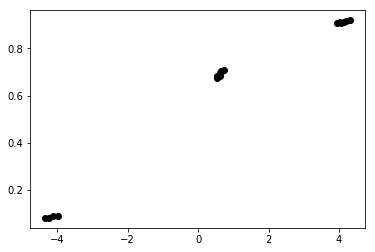

In [408]:
x_axis = alpha
y_axis = np.equal(L, y[:, None]).mean(axis=0)

plt.plot(x_axis, y_axis, 'o', color='black');

**Building 4. (bonus, 2 points)** As it has already been noticed above, models do not matter which class is 1 or 0. Let's say, if all experts turned out to be as disgusting as possible and labeled exactly the opposite, you will have full consistency between the EAs, and it is impossible to understand whether they labeled the sample correctly or not, looking only at this labeling. To avoid this, you can include in the sample a question with a known answer, then you can determine whether the Expert Advisor is labeling deliberately wrong.

To simplify this model in case of tasks with a known label, it is sufficient not to make E-steps for them, but always assume the a posteriori distribution degenerate in the true class. Implement this model and use the true markup *for several* tasks from training. Interpret the results.



In [448]:
def em_with_known_labels(L, y, share_y=0.1, n_steps=1000, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(logbeta))) * 0.5
    
    # select random elements and later will replace part q with these ones
    random_idx = np.random.choice(len(y), size=int(share_y * len(y)))
    known_class = y[random_idx]
    known_q = np.vstack(((1 - known_class, known_class)))
    
    for step in range(n_steps):
        beta = np.exp(logbeta)
        # E-step
        q = posterior(alpha, beta, L)
        q[:, random_idx] = known_q
        # M-step
        alpha += alpha_grad_lb(alpha, beta, L, q) * lr
        logbeta += logbeta_grad_lb(alpha, beta, L, q) * lr
        
    return alpha, logbeta, q

In [449]:
alpha_upd, beta_upd, q_upd = em_with_known_labels(L, y)

In [450]:
alpha

array([ 0.47254296,  0.56694659,  2.93786179,  0.41547294,  0.49933706,
        2.82402114,  0.4652896 ,  2.74372111, -2.75316123,  0.51862865,
       -2.98417416, -2.95401271,  2.7851326 ,  0.43372304,  0.49499731,
        0.40561417,  0.50771661,  2.75155442, -2.71757994,  2.71416665])

In [451]:
alpha_upd

array([-0.62096155, -0.71753481, -4.24641688, -0.52962202, -0.61518362,
       -4.22158215, -0.60964259, -3.88462258,  4.07315631, -0.62639727,
        4.28064901,  4.19462241, -4.09348574, -0.5552842 , -0.63870217,
       -0.53088088, -0.639026  , -4.00542243,  3.96333215, -4.00025312])

# Word Alignment

EM-algorithm is also used in practice for adjusting parameters of word alignment model, more complex modifications of which are used in statistical machine translation. We will not discuss in detail the use of word alignment for translation and will limit ourselves to the following goal: let us have a parallel body of sentences in the source language and their translations into the target language (English and Czech are used in this task, respectively). 

The first task is to define with the help of this corpus how each individual word in the target language is translated. The second task is to determine, for any pair of sentences and its translation, how each word in the target sentence is translated. It turns out that both tasks have an elegant and effective solution when introducing the correct probabilistic model: in this part of the task, you have to implement it and evaluate the results. But about everything in order :)

---

Before we do machine learning, let's look at the data and metrics in the task we are interested in. In the cell below, a parallel English-Czech case is loaded and unzipped, which has a markup of word alignment. It is not difficult to notice that the XML file format used by its authors is not quite standard: there is no ready-made command that would allow to get the list of pairs of sentences together with the alignments. This means that you have to deal with the format and write the parser yourself using Python's built-in tools, such as the [xml] module (https://docs.python.org/3.7/library/xml.html).

In [2]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Task -2.** Implement the `extract_sentences` function which takes the path to the XML markup file used in this dataset and returns a list of parallel sentences as well as a list of "sure" and "possible" alignment pairs. Send your implementation to Yandex.contest to make sure it is correct; in the next cell of the notebook, gather all pairs of marked-up sentences from the dataset into two `all_sentences` (the `SentencePair` list) and `all_targets` (the LabeledAlignment list).

Hereinafter, follow the function signatures and use the classes declared in the module `preprocessing.py` for data organization. It is worth noting that the sentences are already tokenized (even punctuation is separated), so there is no need to pre-process the texts. Pay attention to the format of storing alignments: numbering starts with 1 (in this form and should be saved), the first word in the pair comes from the English sentence.

In [1]:
import glob
from preprocessing import extract_sentences

all_sentences=[]
all_targets=[]

for filename in glob.glob('data/*/*.wa'):
    sents, targets = extract_sentences(filename)
    all_sentences.extend(sents)
    all_targets.extend(targets)

In [453]:
all_sentences

[SentencePair(source=['Relationship', 'of', 'ICOs', 'and', 'ICBs', 'with', 'the', 'Fund'], target=['Vztah', 'mezinárodních', 'organizací', 'pro', 'suroviny', 'a', 'mezinárodních', 'subjektů', 'pro', 'suroviny', 'k', 'fondu']),
 SentencePair(source=['The', 'facilities', 'of', 'the', 'Fund', "'s", 'first', 'account', 'shall', 'be', 'used', 'only', 'by', 'ICOs', 'established', 'to', 'implement', 'the', 'provisions', 'of', 'ICAs', 'providing', 'for', 'either', 'international', 'buffer', 'stocks', 'or', 'internationally', 'coordinated', 'national', 'stocks', ',', 'and', 'which', 'have', 'concluded', 'an', 'association', 'agreement', '.'], target=['Prostředky', 'prvního', 'účtu', 'fondu', 'jsou', 'používány', 'pouze', 'mezinárodními', 'organizacemi', 'pro', 'suroviny', ',', 'které', 'jsou', 'zřízeny', 'za', 'účelem', 'provádění', 'mezinárodních', 'dohod', 'a', 'ujednání', 'o', 'surovinách', 'upravujících', 'mezinárodní', 'regulační', 'nebo', 'mezinárodně', 'koordinované', 'národní', 'sklady'

In [452]:
all_targets

[LabeledAlignment(sure=[(1, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 6), (5, 10), (5, 7), (5, 8), (5, 9), (6, 11), (8, 12)], possible=[(2, 3), (7, 12)]),
 LabeledAlignment(sure=[(10, 5), (11, 6), (12, 7), (14, 10), (14, 11), (14, 8), (14, 9), (15, 15), (16, 16), (16, 17), (2, 1), (21, 19), (21, 20), (21, 21), (21, 22), (21, 23), (21, 24), (22, 25), (25, 26), (26, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (37, 36), (39, 39), (40, 37), (41, 40), (5, 4), (7, 2), (8, 3), (9, 5)], possible=[(1, 1), (13, 9), (15, 12), (15, 13), (15, 14), (17, 18), (18, 18), (19, 18), (20, 20), (23, 25), (24, 28), (3, 3), (3, 4), (36, 36), (38, 37), (39, 38), (4, 3), (4, 4), (6, 4)]),
 LabeledAlignment(sure=[(10, 9), (11, 10), (12, 11), (13, 12), (15, 13), (2, 3), (22, 21), (25, 23), (26, 22), (27, 24), (3, 1), (4, 4), (5, 5), (5, 6), (5, 7), (6, 8)], possible=[(1, 1), (14, 13), (18, 16), (19, 17), (2, 2), (20, 21), (21, 21), (23, 21), (23, 22), (24, 22)]),
 LabeledAl

**Task -1.** Implement `get_token_to_index` and `tokenize_sents` functions from the module `preprocessing.py`, build token->index dictionaries for both languages and build a list from `TokenizedSentencePair` by selection. Also send the function implementations to Yandex.contest.

In [2]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)  

For this task we will take the Daise-focused word alignment method as a baseline: a word in the source language is a translation of a word in the target language if it is often found in the same sentences and rarely occurs separately. 

Mathematically, this is written down by analogy to the Jacquart measure: let $c(x,y)$ be the number of parallel sentences that contain both $x$ (in the target language) and $y$ (in the target language), and $c(x)$ and $c(y)$ be the total number of sentences that contain a word $x$ and $y$ respectively. Then $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ is the "likeness" of the words $x$ and $y$. It is equal to 1 if words occur only in each other's context (there are no sentences only with the word $x$ without $y$ in translation and vice versa), equal to 0 if words never occur in parallel sentences and are between thresholds in other cases.

The file `models.py` describes the abstract class `BaseAligner`, which should be inherited by all models in the task, and also gives an example of implementation `DiceAligner` of word alignment by the way described above. Below you can see how to apply this model.

In [3]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

**Задание 0.** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля quality.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

To estimate the quality of the alignment model using the existing markup, there is a number of automatic metrics. They imply that there are two types of alignments in the markup: "sure" and "possible". Let us denote the first set of alignments as $S$, the second as $P$, and the predicted alignments as $A$ for a particular sentence; moreover, unlike the file markup, $S\subseteq P$. You can then propose three metrics using only operations on these sets:

Precision $=\frac{|A\cap P|}{|A|}$. Reflects how much of the alignment we predicted is correct at all; if we give all possible pairs of words in a sentence as an answer, this metric will ask a lot.

Recall $=\frac{|A\cap S|}{|S|}$. This metric shows what proportion of "confident" alignments we have found. If we try to make an overly conservative model that produces a 0 or 1 prediction on nontrivial sentences, the completeness is extremely low. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. The metric is a combination of the two previous ones and monitors the overall quality of the system, penalizing both the above described undesirable behavior of the model. 

**Task 0.** Implement the functions compute_precision, compute_recall, compute_aer from the quality.py module. Evaluate the quality of the baseline method. Note that you need to use micro-averaging in all functions: sum the numerator and denominator for all sentences and only then divide.

In [5]:
from quality import compute_precision, compute_recall, compute_aer

print(compute_aer(all_targets,baseline.align(tokenized_sentences)))

0.8074618330841489
